In [2]:
import pandas as pd        
import numpy as np  
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic 
from surprise import accuracy

In [4]:
# # Load the dataset
final_data = pd.read_csv('C:\\Users\\LENOVO\\Desktop\\MRS_DS&ML\\data\\final_data.csv')

# Prepare the dataset for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(final_data[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)  

# Number of rating rows in train and test
print("Number of ratings in train set:", trainset.n_ratings)
print("Number of ratings in test set:", len(testset))


Number of ratings in train set: 79429
Number of ratings in test set: 19858


In [21]:
# Random Recommender
def random_recommender(final_data, n=5):
    return final_data.sample(n)['title'].tolist()

print("🎲 Random Recommender Example:")
print(random_recommender(final_data, n=5))

🎲 Random Recommender Example:
['Kundun (1997)', 'Liar Liar (1997)', 'Blade Runner (1982)', 'Keys to Tulsa (1997)', "Dante's Peak (1997)"]


In [23]:
# Popularity Recommender (average rating)
movie_popularity = final_data.groupby('movie_id')['rating'].mean().reset_index()
movie_popularity = movie_popularity.merge(final_data[['movie_id', 'title']], on='movie_id').drop_duplicates() 
movie_popularity = movie_popularity.sort_values(by='rating', ascending=False)

def popularity_recommender(movie_popularity, n=5):
    return movie_popularity.head(n)['title'].tolist()

print("\n⭐ Popularity Recommender Example:")
print(popularity_recommender(movie_popularity, n=5))


⭐ Popularity Recommender Example:
['Pather Panchali (1955)', 'Close Shave, A (1995)', "Schindler's List (1993)", 'Wrong Trousers, The (1993)', 'Casablanca (1942)']


In [24]:
#Random Recommender Predictions for RMSE/MAE

pred_random = [(uid, iid, true_r, np.random.randint(1,6), None) for (uid, iid, true_r) in testset]
rmse_random = accuracy.rmse(pred_random)
mae_random  = accuracy.mae(pred_random)

RMSE: 1.8877
MAE:  1.5175


In [25]:
#Popularity Predictions for RMSE/MAE

movie_avg = final_data.groupby('movie_id')['rating'].mean().to_dict()
pred_popular = [(uid, iid, true_r, movie_avg.get(iid, 3.0), None) for (uid, iid, true_r) in testset]
rmse_pop = accuracy.rmse(pred_popular)
mae_pop  = accuracy.mae(pred_popular)

RMSE: 0.9945
MAE:  0.7936


In [10]:
#User-Based Collaborative Filtering
from surprise.model_selection import cross_validate
# Define similarity options
sim_options = {
    'name': 'cosine',     # similarity measure: cosine or pearson
    'user_based': True    # user-based filtering
}
# Create KNNBasic model
user_knn = KNNBasic(sim_options={'user_based': True})
user_knn.fit(trainset)
# Cross-validate the model
cv_user = cross_validate(user_knn, data, measures=['RMSE','MAE'], cv=3, verbose=True)

rmse_user = np.mean(cv_user['test_rmse'])
mae_user  = np.mean(cv_user['test_mae'])

print(f"\nUser-KNN CV -> RMSE: {rmse_user:.4f}, MAE: {mae_user:.4f}")

# Item-Based Collaborative Filtering
# Define similarity options 
item_Knn = KNNBasic(sim_options={'user_based': False})
item_Knn.fit(trainset)  
# Cross-validate the model
cv_item = cross_validate(item_Knn, data, measures=['RMSE','MAE'], cv=3, verbose=True)   
rmse_item = np.mean(cv_item['test_rmse'])
mae_item  = np.mean(cv_item['test_mae'])
print(f"\nItem-KNN CV -> RMSE: {rmse_item:.4f}, MAE: {mae_item:.4f}")


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9872  0.9757  0.9828  0.9819  0.0047  
MAE (testset)     0.7787  0.7741  0.7792  0.7773  0.0023  
Fit time          0.21    0.19    0.21    0.20    0.01    
Test time         2.46    2.52    2.48    2.49    0.03    

User-KNN CV -> RMSE: 0.9819, MAE: 0.7773
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE

In [13]:
#MAtrix Factorization using SVD

svd_model = SVD()
svd_model.fit(trainset) 
predictions = svd_model.test(testset)
rmse_svd = accuracy.rmse(predictions)
mae_svd = accuracy.mae(predictions) 
print(f"\nSVD Test Set -> RMSE: {rmse_svd:.4f}, MAE: {mae_svd:.4f}")

#NMF model
from surprise import NMF
nmf_model = NMF()
nmf_model.fit(trainset)
predictions_nmf = nmf_model.test(testset)
rmse_nmf = accuracy.rmse(predictions_nmf)
mae_nmf = accuracy.mae(predictions_nmf)
print(f"\nNMF Test Set -> RMSE: {rmse_nmf:.4f}, MAE: {mae_nmf:.4f}")    



RMSE: 0.9291
MAE:  0.7322

SVD Test Set -> RMSE: 0.9291, MAE: 0.7322
RMSE: 0.9546
MAE:  0.7517

NMF Test Set -> RMSE: 0.9546, MAE: 0.7517


In [17]:
from collections import defaultdict

#Precision K function
def precision_recall_at_k(predictions, k=10, threshold=4):
    """Compute Precision@K and Recall@K for each user"""
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = []
    recalls = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in top_k)
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in top_k)

        if n_rel != 0:
            precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0)
            recalls.append(n_rel_and_rec_k / n_rel)

    return np.mean(precisions), np.mean(recalls)

# Precision@10 for SVD
prec_svd, rec_svd = precision_recall_at_k(predictions, k=10, threshold=4)
print(f"\nSVD Precision@10: {prec_svd:.4f}, Recall@10: {rec_svd:.4f}")


# Precision@10 for NMF
prec_nmf, rec_nmf = precision_recall_at_k(predictions_nmf, k=10, threshold=4)
print(f"NMF Precision@10: {prec_nmf:.4f}, Recall@10: {rec_nmf:.4f}")



SVD Precision@10: 0.6495, Recall@10: 0.2968
NMF Precision@10: 0.6243, Recall@10: 0.2884


In [27]:
#visualizations

import seaborn as sns
sns.set(style="whitegrid")

models = ['Random', 'Popularity', 'User-KNN', 'Item-KNN', 'SVD', 'NMF']
rmse_values = [rmse_random, rmse_pop, rmse_user, rmse_item, rmse_svd, rmse_nmf]
mae_values  = [mae_random, mae_pop, mae_user, mae_item, mae_svd, mae_nmf]
precision_10 = [0, 0, 0, 0, prec_svd, prec_nmf]
recall_10    = [0, 0, 0, 0, rec_svd, rec_nmf]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7908\278884654.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=rmse_values, palette='viridis')


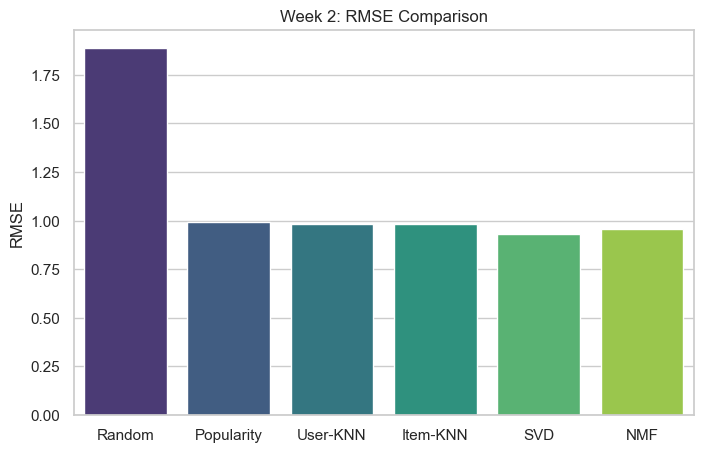

In [28]:
# RMSE
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=rmse_values, palette='viridis')
plt.title("Week 2: RMSE Comparison")
plt.ylabel("RMSE")
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7908\2654522117.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mae_values, palette='magma')


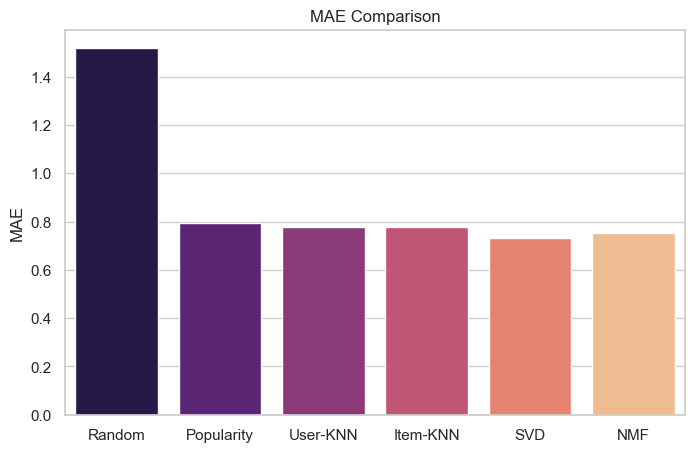

In [29]:
# MAE
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=mae_values, palette='magma')
plt.title("MAE Comparison")
plt.ylabel("MAE")
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7908\4143649324.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=precision_10, palette='coolwarm')


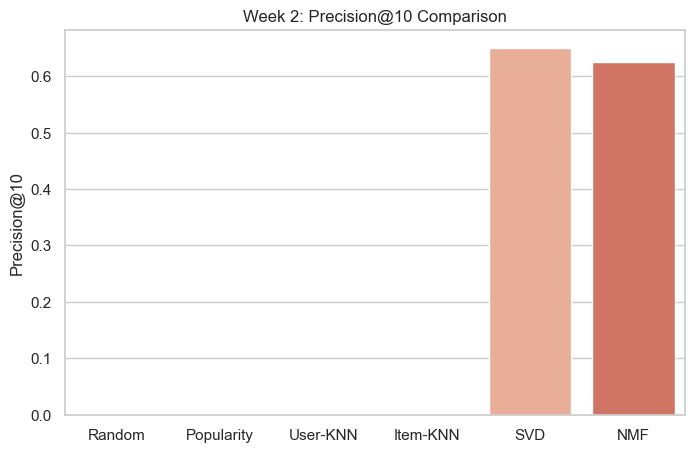

In [30]:
# Precision@10
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=precision_10, palette='coolwarm')
plt.title("Week 2: Precision@10 Comparison")
plt.ylabel("Precision@10")
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7908\340862355.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=recall_10, palette='cubehelix')


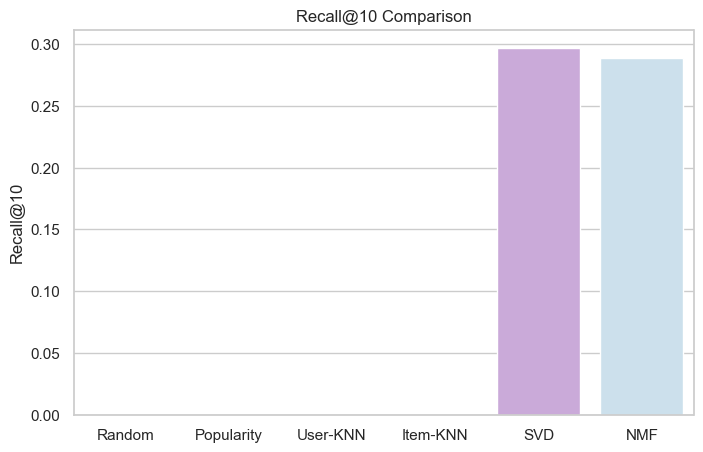

In [31]:
# Recall@10
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=recall_10, palette='cubehelix')
plt.title("Recall@10 Comparison")
plt.ylabel("Recall@10")
plt.show()